# Przetwarzanie obrazów CPSO

Grupa: Mikołaj Baran 241128, Jakub Fałdasz 235730 <br>
Termina zajęć: Czwartek, 7:30-9:00 TN


In [4]:
import numpy as np
import cv2
import scipy as xd
import random
import scipy.ndimage as xd2

from matplotlib import pyplot as plt

def show_img(image_obj, title, gray=False):
    if gray:
        plt.imshow(image_obj, cmap='gray')
    else:
        plt.imshow(image_obj)
    plt.title(title)
    plt.show()

# Zadanie 5

W piątym zadaniu należy utworzyć skrypt umożliwiający wczytanie i wizualizację badanych obrazów poprzez podanie ścieżki do pliku z obrazem. Dodatkowo użytkownik powinien móc wybrać mniejszy prostokątny obszar wczytanego obrazu o zadanych współrzędnych oraz jego zapis do pliku.

Do wczytania i manipulacji obrazem zostanie wykorzystana biblioteka `OpenCV`.

Wczytane obrazki zostaną wyświetlone przy pomocy biblioteki `matplotlib`, jednak aby zrobić to poprawnie należy przekonwertować obrazy wczytane przy użyciu `OpenCV` w formacie `BGR` do formatu `RGB`, który jest obsługiwany przez `matplotlib`.

Podaj ścieżkę do obrazu: 


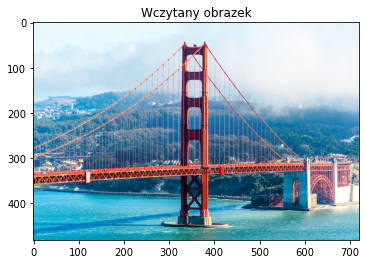

In [5]:
path = input("Podaj ścieżkę do obrazu: ")
if(path == ""):
    path = 'golden_gate.png'
img_bgr = cv2.imread(path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

show_img(img_rgb, "Wczytany obrazek")

Następnie użytkownik może wybrać interesujący go fragment obrazu poprzez podanie jego `wysokości`, `szerokości` i `punktu początkowego obrazu` (zakładając, że punkt [0,0] jest w lewym górnym rogu układu), który zostanie zapisany w wybranym przez użytkownika pliku.

In [3]:
choice = input('Czy chcesz zmienić wielkość wczytanego obrazu? (t / n): ')
choice = choice.lower()
while (choice != 't' and choice != 'n'):
    choice = input('Czy chcesz zmienić wielkość wczytanego obrazu? (t / n): ')
    choice = choice.lower()
    
if choice == 't':
    wrong_input = True
    while(wrong_input):
        try:
            height = int(input("Podaj wysokość wycinka obrazka: "))
            width = int(input("Podaj szerokość wycinka obrazka: "))
            start_x = int(input("Podaj współrzędną x punktu startowego wycinka: "))
            start_y = int(input("Podaj współrzędną y punktu startowego wycinka: "))
        except ValueError:
            print("Musisz podać liczbę!")
            continue
        
        if height + start_y > img_rgb.shape[0] or width + start_x > img_rgb.shape[1] or start_x < 0 or start_y < 0:
            wrong_input = True
            print("\nPodano niepoprawne wymiary.\n")
        else:
            wrong_input = False
    cropped_image = img_rgb[start_y:start_y+height, start_x:start_x+width]
    image_to_save = input("Podaj nazwę pliku do zapisu nowego obrazka: ")
    cv2.imwrite(image_to_save, cropped_image)
    
    show_img(cropped_image, "Wcyinek obrazka")
    
    choice = input('Czy w kolejnych zadaniach chcesz używać utworzonego wycinka? (t / n): ')
    choice.lower()
    while (choice != 't' and choice != 'n'):
        choice = input()
        choice.lower()
        
    if(choice == 't'):
        img = cropped_image
    elif(choice == 'n'):
        img = img_rgb
elif choice == 'n':
    img = img_rgb

KeyboardInterrupt: Interrupted by user

# Zadanie 6

W kolejnym zadaniu należy przeprowadzić na wczytanym obrazku przekształcenia punktowe `T` wg wzoru `s = T(r)`, gdzię `r`,`s`, oznaczają odpowiednio poziom szarości piksela obrazu wejściowe i wyjściowego.

Pierwszą rzeczą jaką należy zrobić jest przekształcenie wczytanego obrazu do skali szarości. Następnie każdy piksel obrazka zostanie pomnożony przez stałą `c` podaną przez użytkownika.

In [ ]:
img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(img_gs, "Obrazek w skali szarości", gray=True)

try:
    c = float(input("Podaj stałą c: "))
except:
    c = 1
    
img_multiplied = img_gs * c
img_multiplied = img_multiplied.astype('uint8')
show_img(img_multiplied, "Obrazek przemnożony przez stałą %f" % c, gray=True)




Następnie możemy zastosować zmianę dynamiki skali szarości (kontrastu) wg poniższego wzoru, gdzie m i e są parametrami ustalonymi przez użytkownika:

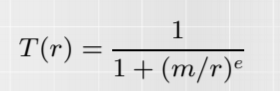

Dodatkowo na wykresie został wykreślone `T(r)`, aby ukazać wpływ T na kontrast obrazu wyjściowego.

Funkcja `contrast(image, m, e):` zwraca obraz ze zmienionym kontrastem oraz przekształcenie poziomów szarości w tablicy `LUT` obliczonych z powyższego wzoru. 

In [ ]:
def contrast(image, m, e):
    LUT = np.empty((1, 256), np.uint8)
    LUT[0,0] = 0
    for i in range(1, 256):
        LUT[0, i] = np.clip(255*(1/(1+pow(m/(i/255), e))), 0, 255)
    return (cv2.LUT(image, LUT), LUT[0])

try:
    m = float(input('Podaj parametr m: '))
    e = float(input('Podaj parametr e: '))
except:
    m = 1
    e = 1

contrasted, LUT = contrast(img_gs, m, e)
show_img(contrasted, "Zmiana kontrastu skali szarości: m = %f, e = %f"% (m, e), gray=True)

plt.plot(range(0, 256), LUT)
plt.xlabel('r')
plt.ylabel('T(r)')
plt.title("Wpływ T na kontrst obrazu wyjściowego m = %f, e = %f" % (m,e))


W kolejnej częsci zadania należało przeprowadzić korekcję gamma, zdefiniowaną $s = c * r^\gamma$, gdzie $c > 0$ i $\gamma > 0$ sa stałymi we wzorze przekształcenia.

In [ ]:
def gamma_correct(image, c, gamma):
    LUT = np.empty((1, 256), np.uint8)
    LUT[0,0] = 0
    for i in range(1, 256):
        LUT[0, i] = np.clip(255*(pow(i/255, gamma)*c), 0, 255)
    return cv2.LUT(image, LUT)

try:
    c = abs(float(input('Podaj parametr c: ')))
    gamma = abs(float(input('Podaj parametr gamma: ')))
except:
    c = 1
    gamma = 1
    
img_gamma = gamma_correct(img_gs, c, gamma)
show_img(img_gamma, "Obrazek po korekcji gamma %f" % c, gray=True)


#  Ćwiczenie 7

W zadaniu 7 zostanie przeprowadzone `wyrównanie histogramu` w celu ukazaniu różnicy w obrazkach, w których dystrybujca wartości pikseli na histogramie zostanie rozcągnięta podobnie jak na poniższym obrazku.
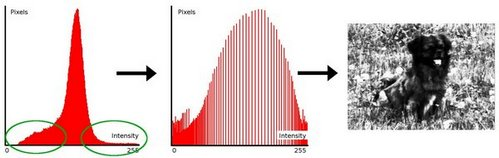

Zostanie wykorzystana do tego funkcja udostępniona przez biblioteke OpenCV `equalizeHist()`.

Poniżej widzimy wyrównanie histogramu wczytanego przez nas obrazka oraz histogramy obrazków przed i po wyrównaniu.

In [36]:
img_eq = cv2.equalizeHist(img_gs)

show_img(img_gs, "Obraz przed wyrównaniem histogramu", gray=True)
show_img(img_eq, "Obraz po wyrównaniu histogramu", gray=True)

histg_before = cv2.calcHist([img_gs], [0], None, [256], [0, 256])
histg_after = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(1)
plt.plot(histg_before)
plt.figure(2)
plt.plot(histg_after)

NameError: name 'img_gs' is not defined

Teraz dla zbyt ciemnego obrazka. 



In [ ]:
img_gamma = gamma_correct(img_gs, 0.5, 5)
img_eq = cv2.equalizeHist(img_gamma)

show_img(img_gamma, "Zbyt ciemny obrazek", gray=True)
show_img(img_eq, "Obraz po wyrównaniu histogramu", gray=True)

histg_before = cv2.calcHist([img_gamma], [0], None, [256], [0, 256])
histg_after = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(1)
plt.plot(histg_before)
plt.figure(2)
plt.plot(histg_after)

In [ ]:
img_gamma = gamma_correct(img_gs, 2, 3)
img_eq = cv2.equalizeHist(img_gamma)

show_img(img_gamma, "Zbyt jasny obrazek", gray=True)
show_img(img_eq, "Obraz po wyrównaniu histogramu", gray=True)

histg_before = cv2.calcHist([img_gamma], [0], None, [256], [0, 256])
histg_after = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(1)
plt.plot(histg_before)
plt.figure(2)
plt.plot(histg_after)

# Zadanie 8

Na samym początku tworzymy funkcje która będzie odpowiadała za zaszumienie naszego obrazu. Jako argumenty przyjmuje ona obrazek oraz prawdopodobieństwo wystąpienia szumu na danym pikselu. Najpierw nasze wyjściowe zdjęcie inicjujemy zerami a następnie przechodząc przez każdy piksel losujemy liczbę. Jeżeli liczba ta jest mniejsza od podanego przez nas prawdopodobieństwa ustawiamy piksel na biały a jeżeli więszksza od (prawdopodobieństwo - 1) to na czarny. W innym wypadku po prostu kopiujemy wartość piksela z orginalnego obrazka.

In [6]:
def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


Wczytujemy obrazek i zaszumiamy go utworzoną wcześniej funkcją. Filtry będą testowane podając prawdopodobieństwo zmiany piksela równe `0.03` co daje dobrze zauważalny efekt.

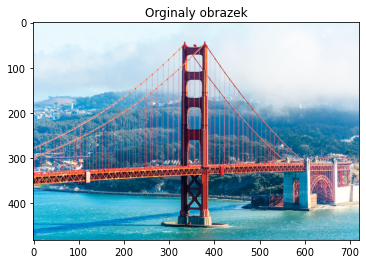

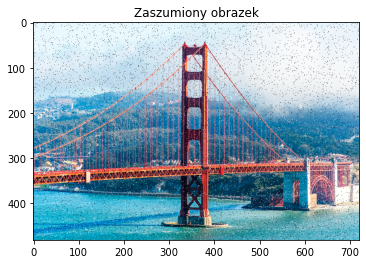

In [7]:
path = 'golden_gate.png'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_img(image,"Orginaly obrazek")
image_noise = sp_noise(image,0.02)
show_img(image_noise,"Zaszumiony obrazek")

a)
<br>
Przeprowadzimy test na maskach o rozmiarze `3`, `5`, `7`, `11` oraz `15`. Użyjemy również funkcji `blur` która nakłada odpowiednią maske na obrazek.

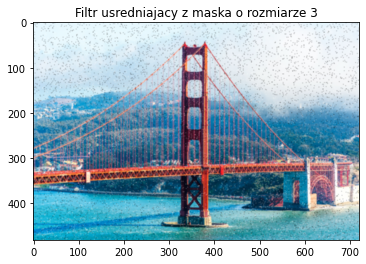

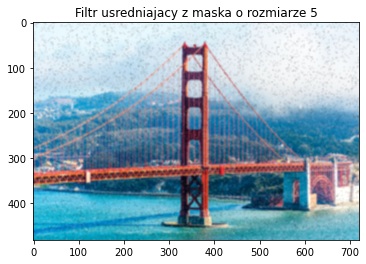

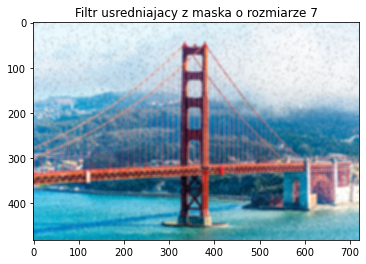

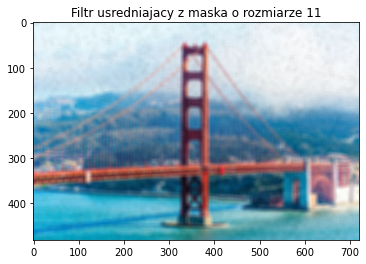

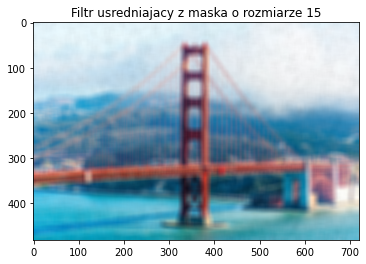

In [8]:
for size in [3,5,7,11,15]:
    blur = cv2.blur(image_noise,(size,size))
    show_img(blur,f"Filtr usredniajacy z maska o rozmiarze {size}")

Najlepiej spisała się maska o rzmiarze `5` jednak jak widać, ogólnie filtr uśredniający nie sprawdził się zbyt dobrze w usuwaniu szumów. Dla małych masek szum jest cały czas widoczny a stopniowe ich zwiększanie za bardzo rozmazuje obraz. 

b)
<br>
Tak samo jak w punkcie `a)` testy przeprowadzimy na maskach o rozmiarze `3`, `5`, `7`, `11` oraz `15`. Użyjemy funkcji `medianBlur` która nakłada filtr medianowy z odpowiednią maską.

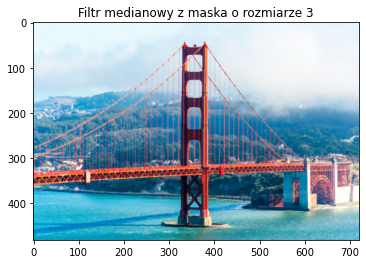

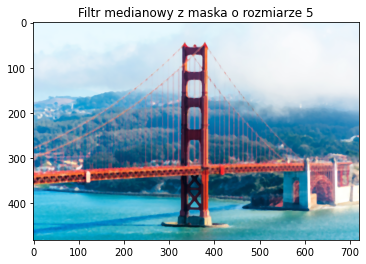

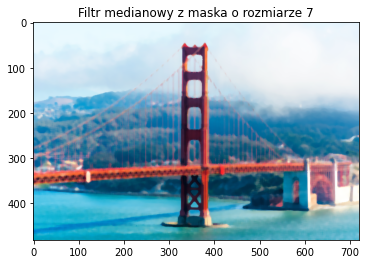

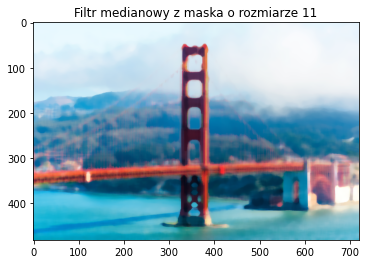

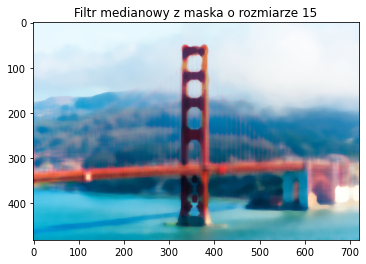

In [15]:
for size in [3,5,7,11,15]:
    median = cv2.medianBlur(image_noise, size)
    show_img(median, f"Filtr medianowy z maska o rozmiarze {size}")

Filtr medianowy okazał się dużo skuteczniejszy. Maska o rozmiarze `3` usuneła cały szum z obrazka oraz zachowała zadowalający poziom ostrości. Zwiększanie rozmiaru maski nie było tutaj koniecznie ponieważ dało przewidywany efekt tylko coraz bardziej rozmywając braz. 

# Zadanie 9

a)

Za pomocą operacji dwuwymiarowego dyskretnego splotu macierzy obrazu z macierzą 3x3 charakterystyczną dla danego kierunku zwaną jądrem (ang. kernel) przekształcenia możemy wykryć poszczególne krawędzie o określonym położeniu.
<br>
<br>
Użyte maski:
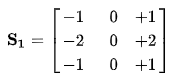
do wykrycia krawędzi pionowych,
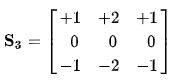
do wykrycia krawędzi poziomych,
<br>
Odpowiednio ustawiając maski można też wykrywać krawędzie pod kątem 45 stopni.
<br>
<br>
W celu uproszczenia obliczeń zmieniamy format poszczególych obrazków z `RGB` na odcienie szarości. Dzięki temu przetwarzamy obrazu zapisany w tablicy dwu-wymiarowej a nie trzy-wymiarowej i mogliśmy napisać własną motodę do splotu.

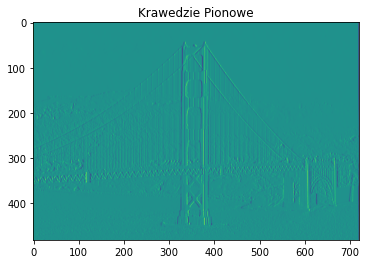

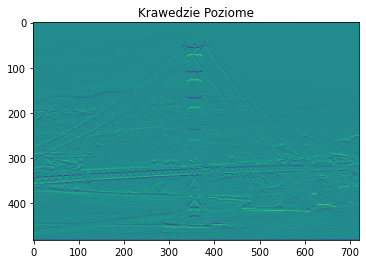

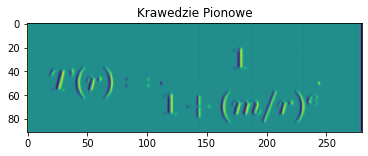

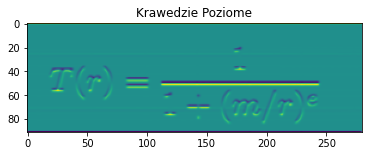

In [17]:
def convolution(image, kernel):
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
    return output

filter_vertical = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
filter_horizontal = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

images_names = ['golden_gate.png', 'wzor.png']
images = [cv2.imread(i,0) for i in images_names]

for image in images:
    new_image_x = convolution(image, filter_vertical)
    show_img(new_image_x,"Krawedzie Pionowe")
    new_image_y = convolution(image, filter_horizontal)
    show_img(new_image_y,"Krawedzie Poziome")



Najlepiej widoczne wykrycie poszczególnych krawędzie możemy zobaczyć na zdjęciu wzoru przy znaku `=`, `+` oraz `kresce ułmkowej`. Na zdjęciu z krawędziami pionowymi ich praktycznie nie widać za to na zdjęciu z krawędziami poziomymi są bardzo dobrze widoczne.

b)

Do testów użyto masek filtrów o rozmiarach `1`, `9`, `17`, `25`, `31`. Ostatnia wartość to maksimum jakie przyjmuje funkcja `Laplacian` z modułu `cv2`która nakłada odpowiedni filtr na obraz. Jako argumenty przyjmuje ona kolejno obraz do przetworzenia, enum na ilu bitach może być reprezentowana szrość piksela (u nas 64) oraz rozmiar maski.
<br>
Wizualizacja działania `Laplasjanu` zostanie przeprowdzona na obrazku `golden_gate.png`.

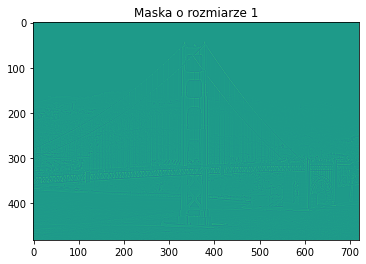

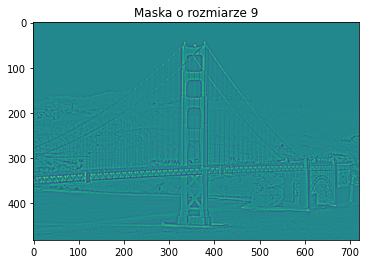

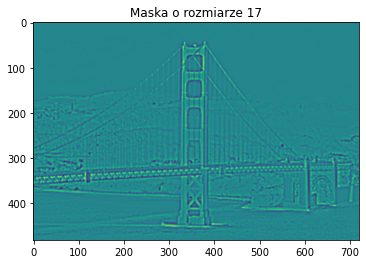

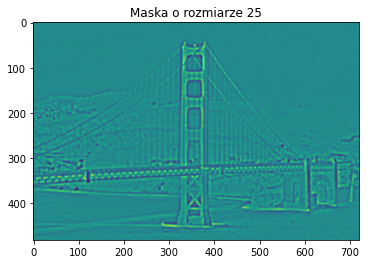

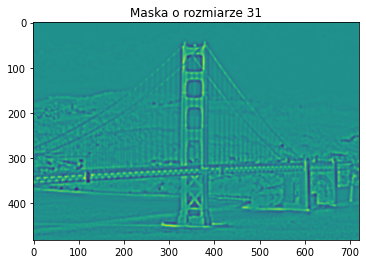

In [18]:
kernel_sizes_to_test = [1,9,17,25,31]
path = 'golden_gate.png'
image = cv2.imread(path,0)

for kernel_size in kernel_sizes_to_test:
    laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=kernel_size)
    show_img(laplacian,f"Maska o rozmiarze {kernel_size}")

Jak widać dla romiaru maski 1 czyli:
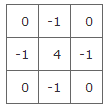
krawędzie są bardzo słabo widoczne. Dużo lepiej jest w przypadku maski o rozmiarze 9 gdzie brzegi są ostre i dobrze widoczne.
<br>
<br>
Dalsze zwiększanie maski już tylko pogarszało obraz rozmywając go dlatego ważne jest aby dobrać `Laplasjan` do danego obrazu. 